## 1. Import Libraries and Mount Drive

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Define Directory Paths

In [3]:
base_path = '/content/drive/My Drive/Dataverse_Foodora_Project'

# Define sub-folder paths
input_path = os.path.join(base_path, '01_Input_Data')
processed_path = os.path.join(base_path, '03_Processed_Data')

# specific file paths
foodora_file = os.path.join(input_path, 'Foodora Data.csv')
country_file = os.path.join(input_path, 'Country-Code.xlsx')

print("Paths set successfully.")
print(f"Input Path: {input_path}")
print(f"Processed Path: {processed_path}")

Paths set successfully.
Input Path: /content/drive/My Drive/Dataverse_Foodora_Project/01_Input_Data
Processed Path: /content/drive/My Drive/Dataverse_Foodora_Project/03_Processed_Data


## 3. Load Dataframes: Loading the main restaurant data & the country code data

In [4]:
# Loading the main restaurant data
try:
    df_foodora = pd.read_csv(foodora_file, encoding='ISO-8859-1')
    print("Foodora Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Could not find file at {foodora_file}. Please check file name and path.")

# Loading the country code data
try:
    df_country = pd.read_excel(country_file)
    print("Country Code Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Could not find file at {country_file}. Please check file name and path.")

Foodora Data loaded successfully.
Country Code Data loaded successfully.


In [5]:
# Inspect the restaurant dataset
df_foodora.shape

(9551, 21)

In [6]:
# Inspect the restaurant dataset column names
df_foodora.columns

Index(['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes'],
      dtype='object')

In [7]:
# Inspect the country dataset
df_country.shape

(15, 2)

In [8]:
# Inspect the country code dataset column names
df_country.columns

Index(['Country Code', 'Country'], dtype='object')

## 4. Merge foodora data with country codes

### Merging Restaurant and Country Datasets

The restaurant dataset uses numeric country codes.
To enable meaningful geographic analysis, we merge the restaurant dataset
with the country dataset using Country Code.

This enriches the restaurant data with readable country names.

In [9]:
df_updated_foodora = pd.merge(df_foodora, df_country, on='Country Code', how='left')

# Check if merge was successful
print(f"Shape after merge: {df_updated_foodora.shape}")
print("First 5 rows of merged Country column:")
print(df_updated_foodora[['Restaurant Name', 'Country']].head())

Shape after merge: (9551, 22)
First 5 rows of merged Country column:
          Restaurant Name      Country
0        Le Petit Souffle  Phillipines
1        Izakaya Kikufuji  Phillipines
2  Heat - Edsa Shangri-La  Phillipines
3                    Ooma  Phillipines
4             Sambo Kojin  Phillipines


In [10]:
# Check for missing country names after merge
df_updated_foodora['Country'].isna().sum()

np.int64(0)

In [11]:
# Unique countries count
df_updated_foodora['Country'].nunique()

15

### Post Merge Validation

After merging, we verify that:
- The Country column is correctly populated
- No rows were lost during the merge
- Country names are readable and usable for analysis


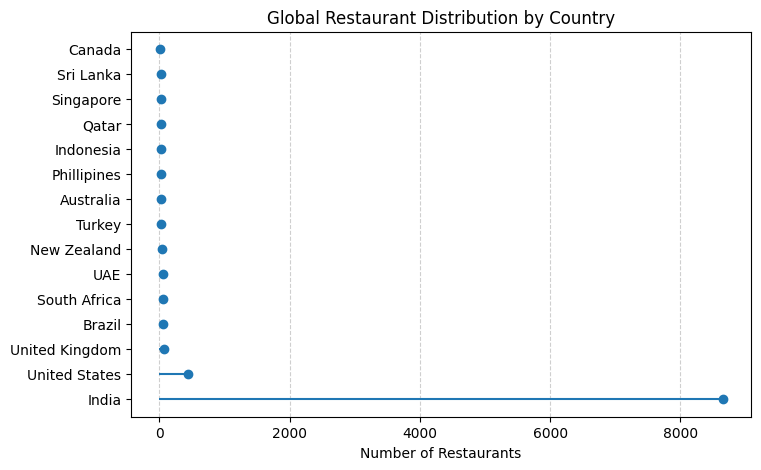

In [12]:
import matplotlib.pyplot as plt

country_counts = df_updated_foodora['Country'].value_counts()

plt.figure(figsize=(8,5))
plt.hlines(
    y=country_counts.index,
    xmin=0,
    xmax=country_counts.values
)
plt.plot(country_counts.values, country_counts.index, "o")
plt.xlabel("Number of Restaurants")
plt.title("Global Restaurant Distribution by Country")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

## 5. Dropping Country Code Column

Once the Country name is available, the numeric Country Code
is no longer required for analysis.

Dropping this column improves readability and reduces redundancy.


In [13]:
# Drop Country Code column
df_updated_foodora.drop(columns=['Country Code'], inplace=True)

# Confirm removal
df_updated_foodora.columns

Index(['Restaurant ID', 'Restaurant Name', 'City', 'Address', 'Locality',
       'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes', 'Country'],
      dtype='object')

### Reordering Columns for Geographic Readability

For clearer geographic analysis, we move the `Country` column
next to the `City` column.

This improves readability when exploring city-level and
country-level patterns together.

In [14]:
# Get current column order
cols = df_updated_foodora.columns.tolist()

# Remove Country from its current position
cols.remove('Country')

# Find index of City and insert Country right after it
city_index = cols.index('City')
cols.insert(city_index + 1, 'Country')

# Reorder dataframe
df_updated_foodora = df_updated_foodora[cols]

# Verify new order
df_updated_foodora.columns

Index(['Restaurant ID', 'Restaurant Name', 'City', 'Country', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes'],
      dtype='object')

## 6. Dropping Redundant and Non-Informative Columns

Not all columns in a dataset contribute meaningful information for analysis.
Some columns add redundancy, while others contain no variability and therefore
cannot explain or predict any outcome.

1. **Locality Verbose**
   - This column is a more descriptive text version of the `Locality` column.
   - It largely repeats the same information with additional words or formatting.
   - Using both can introduce noise without adding new analytical signals.
   - Retaining only `Locality` is sufficient for locality-level analysis.

2. **Switch to order menu**
   - This column contains the same value for all rows.
   - Columns with a single unique value have zero variance.
   - Such columns do not contribute to EDA, correlation analysis, or modeling.
   - Keeping them only increases dimensionality without adding insight.

Dropping these columns simplifies the dataset and improves analytical clarity.

In [15]:
# Check uniqueness in Locality vs Locality Verbose
df_updated_foodora[['Locality', 'Locality Verbose']].head(10)

,Locality,Locality Verbose
0,"Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak..."
1,"Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma..."
2,"Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma..."
3,"SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal..."
4,"SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal..."
5,"SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal..."
6,"SM by the Bay, Mall of Asia Complex, Pasay City","SM by the Bay, Mall of Asia Complex, Pasay Cit..."
7,"SM by the Bay, Mall of Asia Complex, Pasay City","SM by the Bay, Mall of Asia Complex, Pasay Cit..."
8,"Sofitel Philippine Plaza Manila, Pasay City","Sofitel Philippine Plaza Manila, Pasay City, P..."
9,Kapitolyo,"Kapitolyo, Pasig City"


In [16]:
# Number of unique values in Switch to order menu
df_updated_foodora['Switch to order menu'].value_counts()

,count
Switch to order menu,
No,9551


In [17]:
# Drop non-informative and redundant columns
df_updated_foodora.drop(
    columns=['Locality Verbose', 'Switch to order menu'],
    inplace=True
)

# Confirm columns are removed
df_updated_foodora.columns

Index(['Restaurant ID', 'Restaurant Name', 'City', 'Country', 'Address',
       'Locality', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two',
       'Currency', 'Has Table booking', 'Has Online delivery',
       'Is delivering now', 'Price range', 'Aggregate rating', 'Rating color',
       'Rating text', 'Votes'],
      dtype='object')

## 7. Dataset Size, Structure Validation, & Column Validation

Before proceeding with analysis, it is important to validate the size
and structure of the dataset. This ensures that data ingestion and
merging steps were completed successfully.

We verify:
- `df.info` Prints a concise summary of the dataframe's structure, including data types, non-null counts, and memory usage.

- `df.describe` Generates descriptive statistics that summarize the central tendency, dispersion, and shape of numerical columns.


In [18]:
df_updated_foodora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   City                  9551 non-null   object 
 3   Country               9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Longitude             9551 non-null   float64
 7   Latitude              9551 non-null   float64
 8   Cuisines              9542 non-null   object 
 9   Average Cost for two  9551 non-null   int64  
 10  Currency              9551 non-null   object 
 11  Has Table booking     9551 non-null   object 
 12  Has Online delivery   9551 non-null   object 
 13  Is delivering now     9551 non-null   object 
 14  Price range           9551 non-null   int64  
 15  Aggregate rating     

### Identifying Missing Values in the Cuisines Column

During the initial data sanity check using the dataset information,
we observed that the `Cuisines` column contains a small number of
missing values.

Out of the total dataset, only 9 restaurants do not have cuisine
information. This represents a very small fraction of the data and
does not indicate a systemic data quality issue.

Understanding and documenting this is important so that these
rows are handled appropriately in downstream analysis rather than
being dropped blindly.


In [19]:
# Check missing values in all columns
df_updated_foodora.isna().sum()

,0
Restaurant ID,0
Restaurant Name,0
City,0
Country,0
Address,0
Locality,0
Longitude,0
Latitude,0
Cuisines,9
Average Cost for two,0


In [20]:
# Explicitly check missing values in Cuisines
df_updated_foodora['Cuisines'].isna().sum()

np.int64(9)

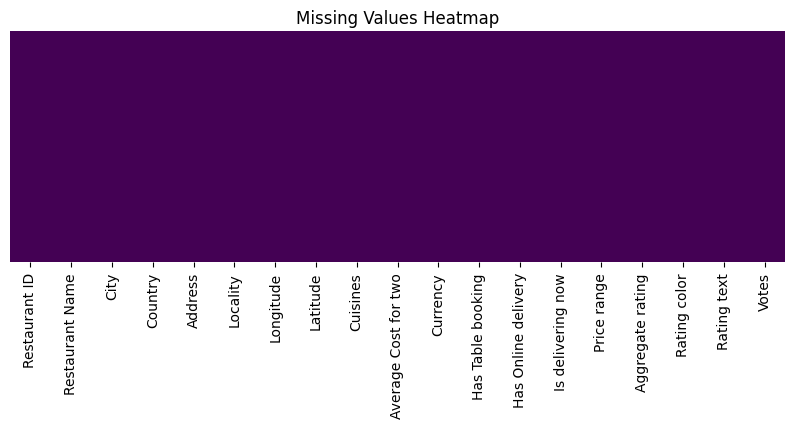

In [21]:
plt.figure(figsize=(10,3))
sns.heatmap(
    df_updated_foodora.isna(),
    cbar=False,
    yticklabels=False,
    cmap='viridis'
)
plt.title("Missing Values Heatmap")
plt.show()

### Strategy for Handling Missing Cuisine Values

We adopt a context-aware strategy instead of a one-size-fits-all approach.

**Restaurant-Level Analysis**
- Restaurants with missing cuisine information are retained.
- Cuisine is not mandatory for analyzing city performance, ratings,
  delivery adoption, or pricing trends.
- This avoids unnecessary data loss.

**Cuisine-Level Analysis**
- Restaurants with missing cuisine information are excluded only when
  performing cuisine-specific analysis.
- A restaurant without a cuisine label cannot contribute meaningful
  insights at the cuisine level.

This two-tier handling strategy ensures analytical accuracy while
preserving the integrity of the overall dataset.

In [22]:
df_updated_foodora.describe()

,Restaurant ID,Longitude,Latitude,Average Cost for two,Price range,Aggregate rating,Votes
count,9.551000e+03,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000
mean,9.051128e+06,64.126574,25.854381,1199.210763,1.804837,2.666370,156.909748
std,8.791521e+06,41.467058,11.007935,16121.183073,0.905609,1.516378,430.169145
min,5.300000e+01,-157.948486,-41.330428,0.000000,1.000000,0.000000,0.000000
25%,3.019625e+05,77.081343,28.478713,250.000000,1.000000,2.500000,5.000000
50%,6.004089e+06,77.191964,28.570469,400.000000,2.000000,3.200000,31.000000
75%,1.835229e+07,77.282006,28.642758,700.000000,2.000000,3.700000,131.000000
max,1.850065e+07,174.832089,55.976980,800000.000000,4.000000,4.900000,10934.000000


### Geographic Coverage Validation

Understanding geographic coverage helps frame the scope of analysis.
We check the number of unique countries and cities to assess
global presence and regional diversity.

The dataset shows strong representation from India, making both
global and India-specific analysis feasible.

In [23]:
# Number of unique countries
df_updated_foodora['Country'].nunique()

15

In [24]:
df_updated_foodora['Country'].value_counts()

,count
Country,
India,8652
United States,434
United Kingdom,80
Brazil,60
South Africa,60
UAE,60
New Zealand,40
Turkey,34
Australia,24


In [25]:
# Number of unique cities
df_updated_foodora['City'].nunique()

141

In [26]:
df_updated_foodora.groupby('Country')['City'].nunique().sort_values(ascending=False)

,City
Country,
India,43
United States,35
Australia,23
Phillipines,9
South Africa,6
Indonesia,4
Canada,4
United Kingdom,4
Brazil,3


### Rating Semantics and Quality Assessment

Ratings are a primary indicator of customer satisfaction on the platform.
Before using them for analysis, it is essential to understand their scale
and meaning.

From the dataset, we observe that:
- Aggregate ratings lie between 0 and 5
- A rating value of 0 does not indicate poor quality
- Instead, it represents restaurants that have not received any ratings

This distinction is important because unrated restaurants should not be
interpreted as low quality, but rather as having limited visibility or
insufficient customer feedback.


In [27]:
# Check minimum and maximum rating values
df_updated_foodora['Aggregate rating'].min(), df_updated_foodora['Aggregate rating'].max()

(0.0, 4.9)

### Identifying Unrated Restaurants

To quantify the impact of unrated restaurants on the platform,
we calculate how many restaurants have an aggregate rating of 0.

This helps distinguish between:
- Restaurants with customer feedback
- Restaurants lacking sufficient visibility or engagement

In [28]:
# Create a flag for rated vs unrated restaurants
df_updated_foodora['is_rated'] = df_updated_foodora['Aggregate rating'].apply(
    lambda x: 0 if x == 0 else 1
)

# Count rated and unrated restaurants
df_updated_foodora['is_rated'].value_counts()

,count
is_rated,
1,7403
0,2148


### Proportion of Unrated Restaurants

Understanding the proportion of unrated restaurants helps assess
the scale of the visibility and trust gap on the platform.

A large percentage of unrated restaurants indicates potential issues
in discovery, engagement, or onboarding.

In [29]:
# Percentage of rated vs unrated restaurants
(df_updated_foodora['is_rated'].value_counts() / len(df_updated_foodora)) * 100

,count
is_rated,
1,77.510208
0,22.489792


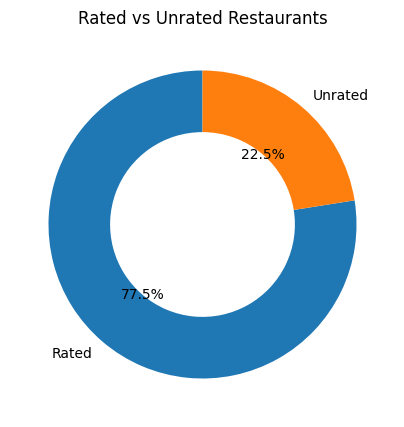

In [30]:
rated_counts = df_updated_foodora['is_rated'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(
    rated_counts,
    labels=['Rated', 'Unrated'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width':0.4}
)
plt.title("Rated vs Unrated Restaurants")
plt.show()

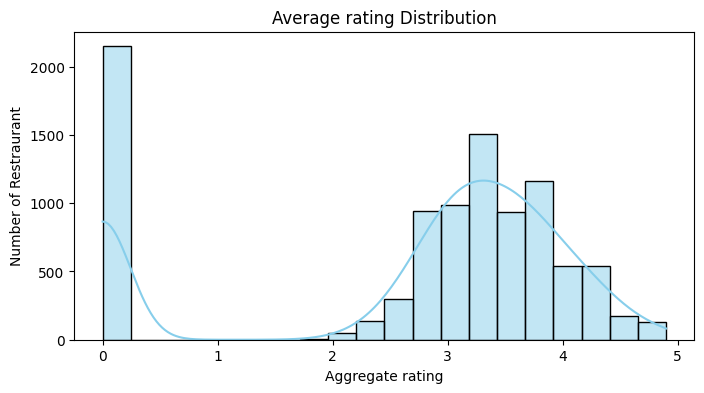

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(8, 4))
sns.histplot(df_updated_foodora['Aggregate rating'], bins=20, kde=True, color='skyblue')
plt.title('Average rating Distribution')
plt.xlabel('Aggregate rating')
plt.ylabel('Number of Restraurant')
plt.show()

### Analytical Decision Based on Rating Semantics

Given that a significant portion of restaurants are unrated,
we adopt a split-analysis approach:

- **Rated Restaurants**
  - Used for customer satisfaction analysis
  - Suitable for rating-based comparisons and modeling

- **Unrated Restaurants**
  - Analyzed separately to understand visibility gaps
  - Useful for identifying onboarding or discovery issues

This approach prevents analytical bias and ensures that unrated
restaurants are interpreted correctly.


## 8. Currency Data Quality Issue Identification

In [32]:
df_updated_foodora.groupby('Country')['Currency'].unique()

,Currency
Country,
Australia,[Dollar($)]
Brazil,[Brazilian Real(R$)]
Canada,[Dollar($)]
India,[Indian Rupees(Rs.)]
Indonesia,[Indonesian Rupiah(IDR)]
New Zealand,[NewZealand($)]
Phillipines,[Botswana Pula(P)]
Qatar,[Qatari Rial(QR)]
Singapore,[Dollar($)]


### Identifying Currency Data Quality Issues

During exploratory analysis, we observed inconsistencies between the
`Country` and `Currency` columns.

In particular, some restaurants located in the Philippines are tagged
with `Botswana Pula (P)` as their currency, which is factually incorrect.
The official currency of the Philippines is the Philippine Peso (PHP).

This inconsistency indicates a dataset source issue rather than a
processing or merge error and must be corrected before any cost analysis.


In [33]:
# Inspect currencies used for Philippines
df_updated_foodora[df_updated_foodora['Country'] == 'Phillipines']['Currency'].value_counts()

,count
Currency,
Botswana Pula(P),22


### Interpreting the Currency Issue

Since the mismatch appears only for specific countries and not as a
system-wide problem, we conclude that:
- The issue originates from the raw dataset
- Blindly trusting the Currency column would corrupt cost comparisons

Therefore, currency correction must be handled explicitly before
normalization.


### Currency Normalization Strategy

To enable fair comparison of restaurant costs across countries,
all prices must be converted into a single currency.

Our strategy is as follows:
- Retain the original `Currency` column for transparency
- Override currency logic based on the `Country` column
- Apply a country-specific correction only where required
- Convert all costs into INR using static exchange rates

This ensures analytical correctness without discarding original data.


In [34]:
# Correct currency mapping based on country
country_to_currency = {
    'India': 'INR',
    'Australia': 'AUD',
    'Brazil': 'BRL',
    'Canada': 'CAD',
    'United States': 'USD',
    'United Kingdom': 'GBP',
    'Indonesia': 'IDR',
    'New Zealand': 'NZD',
    'South Africa': 'ZAR',
    'Phillipines': 'PHP',
    'UAE': 'AED',
    'Turkey': 'TRY',
    'Sri Lanka': 'LKR',
    'Qatar': 'QAR',
    'Singapore': 'SGD'
}

# Assign corrected currency based on country
df_updated_foodora['correct_currency'] = df_updated_foodora['Country'].map(country_to_currency)

df_updated_foodora[['Country', 'Currency', 'correct_currency']].head(10)


,Country,Currency,correct_currency
0,Phillipines,Botswana Pula(P),PHP
1,Phillipines,Botswana Pula(P),PHP
2,Phillipines,Botswana Pula(P),PHP
3,Phillipines,Botswana Pula(P),PHP
4,Phillipines,Botswana Pula(P),PHP
5,Phillipines,Botswana Pula(P),PHP
6,Phillipines,Botswana Pula(P),PHP
7,Phillipines,Botswana Pula(P),PHP
8,Phillipines,Botswana Pula(P),PHP
9,Phillipines,Botswana Pula(P),PHP


### Handling Philippines Currency Exception

For Philippines, the dataset incorrectly assigns Botswana Pula.
Instead of using the dataset currency, we assign Philippine Peso (PHP)
based on the country mapping.

This ensures that cost values are interpreted correctly before INR conversion.

In [35]:
# Verify corrected currency for Philippines
df_updated_foodora[df_updated_foodora['Country'] == 'Phillipines']['correct_currency'].value_counts()

,count
correct_currency,
PHP,22


### Exchange Rates and INR Conversion

Static exchange rates are used to convert all restaurant costs into INR.
These rates are sufficient for analytical and comparative purposes and
avoid reliance on live external APIs.

A new column `avg_cost_for_two_inr` is created to store normalized costs.

In [36]:
# Static approximate exchange rates to INR (names corrected, values unchanged)
currency_to_inr = {
    'INR': 1,            # Indian Rupees(Rs.)
    'USD': 90,           # Dollar($)
    'BRL': 16.5,         # Brazilian Real(R$)
    'GBP': 121,          # Pounds(£)
    'NZD': 51,           # NewZealand($)
    'ZAR': 5.41,         # Rand(R)
    'PHP': 1.5,          # Philippine Peso(P)
    'QAR': 24.94,        # Qatari Rial(QR)
    'IDR': 0.0055,       # Indonesian Rupiah(IDR)
    'LKR': 0.29,         # Sri Lankan Rupee(LKR)
    'TRY': 2.13,         # Turkish Lira(TL)
    'AED': 24.72,        # Emirati Diram(AED)
    'SGD': 70.39,        # Singapore Dollar(SGD)
    'CAD': 65.91,        # Canadian Dollar(CAD)
    'EUR': 106.67,       # Euro(€)
    'AUD': 60.32         # Australian Dollar(AUD)
}

In [37]:
# Convert average cost for two into INR
df_updated_foodora['avg_cost_for_two_inr'] = (
    df_updated_foodora['Average Cost for two'] *
    df_updated_foodora['correct_currency'].map(currency_to_inr)
)

df_updated_foodora[['Country', 'Average Cost for two', 'correct_currency', 'avg_cost_for_two_inr']].head(10)

,Country,Average Cost for two,correct_currency,avg_cost_for_two_inr
0,Phillipines,1100,PHP,1650.0
1,Phillipines,1200,PHP,1800.0
2,Phillipines,4000,PHP,6000.0
3,Phillipines,1500,PHP,2250.0
4,Phillipines,1500,PHP,2250.0
5,Phillipines,1000,PHP,1500.0
6,Phillipines,2000,PHP,3000.0
7,Phillipines,2000,PHP,3000.0
8,Phillipines,6000,PHP,9000.0
9,Phillipines,1100,PHP,1650.0


### Validation and Traceability

The original cost and currency columns are retained alongside the
normalized INR column.

This allows:
- Verification of conversion logic
- Auditability of currency corrections
- Transparent reporting of assumptions

In [38]:
# Check for any missing INR values after conversion
df_updated_foodora['avg_cost_for_two_inr'].isna().sum()

np.int64(0)

In [39]:
# Final validation after currency standardization and conversion
df_updated_foodora[['correct_currency', 'avg_cost_for_two_inr']].isna().sum()


,0
correct_currency,0
avg_cost_for_two_inr,0


In [40]:
# Summary statistics of normalized cost
df_updated_foodora['avg_cost_for_two_inr'].describe()

,avg_cost_for_two_inr
count,9551.00000
mean,839.40168
std,1288.08127
min,0.00000
25%,300.00000
50%,500.00000
75%,850.00000
max,35195.00000


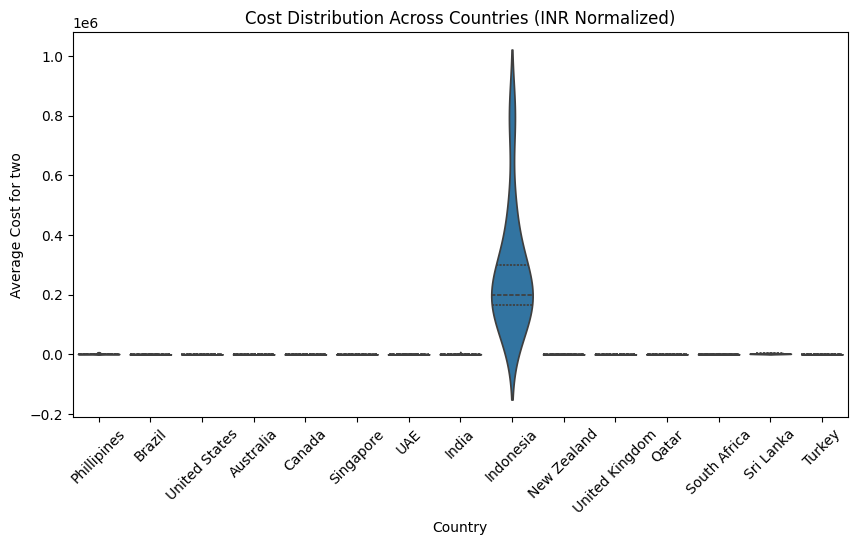

In [41]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.violinplot(
    x='Country',
    y='Average Cost for two',
    data=df_updated_foodora,
    inner='quartile',
    scale='width'
)
plt.xticks(rotation=45)
plt.title("Cost Distribution Across Countries (INR Normalized)")
plt.show()

In [42]:
# 2 coljumns for 'Average Cost for two'
df_updated_foodora.columns

Index(['Restaurant ID', 'Restaurant Name', 'City', 'Country', 'Address',
       'Locality', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two',
       'Currency', 'Has Table booking', 'Has Online delivery',
       'Is delivering now', 'Price range', 'Aggregate rating', 'Rating color',
       'Rating text', 'Votes', 'is_rated', 'correct_currency',
       'avg_cost_for_two_inr'],
      dtype='object')

### Dropping Original Cost Column

The original `Average Cost for two` column contains values in multiple
currencies and is affected by known currency inconsistencies.

After converting all costs to INR using country-based correction,
the original column no longer represents reliable or comparable data.

To avoid analytical errors and ensure consistency, the original
cost column is removed and replaced by the INR-normalized version.

In [43]:
# Drop original cost column
df_updated_foodora.drop(columns=['Average Cost for two'], inplace=True)

# Rename INR-normalized column as the primary cost feature
df_updated_foodora.rename(
    columns={'avg_cost_for_two_inr': 'Average Cost for two'},
    inplace=True
)

# Verify
df_updated_foodora[['Country', 'Average Cost for two']].head()

,Country,Average Cost for two
0,Phillipines,1650.0
1,Phillipines,1800.0
2,Phillipines,6000.0
3,Phillipines,2250.0
4,Phillipines,2250.0


In [44]:
# Now only 1 column for 'Average Cost for two'
df_updated_foodora.columns

Index(['Restaurant ID', 'Restaurant Name', 'City', 'Country', 'Address',
       'Locality', 'Longitude', 'Latitude', 'Cuisines', 'Currency',
       'Has Table booking', 'Has Online delivery', 'Is delivering now',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes', 'is_rated', 'correct_currency', 'Average Cost for two'],
      dtype='object')

### Final Column Cleanup and Reordering

After normalizing costs and correcting currencies:
- The original `Currency` column is no longer required
- `correct_currency` becomes the authoritative currency column
- The normalized `Average Cost for two` column is repositioned next to `Cuisines`
  to preserve the original logical structure of the dataset

This step finalizes the dataset structure for analysis and modeling.

In [45]:
# 1. Drop old Currency column
df_updated_foodora.drop(columns=['Currency'], inplace=True)

# 2. Rename correct_currency to Currency
df_updated_foodora.rename(
    columns={'correct_currency': 'Currency'},
    inplace=True
)

# 3. Reorder columns to place Average Cost for two next to Cuisines
cols = df_updated_foodora.columns.tolist()

# Remove column from current position
cols.remove('Average Cost for two')

# Insert it right after Cuisines
cuisine_index = cols.index('Cuisines')
cols.insert(cuisine_index + 1, 'Average Cost for two')

# Apply new order
df_updated_foodora = df_updated_foodora[cols]

# Verify final column order
df_updated_foodora.columns

Index(['Restaurant ID', 'Restaurant Name', 'City', 'Country', 'Address',
       'Locality', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two',
       'Has Table booking', 'Has Online delivery', 'Is delivering now',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes', 'is_rated', 'Currency'],
      dtype='object')

### Reordering Currency Next to Average Cost

For better readability and consistency, the `Currency` column is placed
immediately next to `Average Cost for two`.

This keeps monetary value and its unit together, which is important for
EDA, reporting, and modeling clarity.

In [46]:
# Get current column order
cols = df_updated_foodora.columns.tolist()

# Remove Currency from its current position
cols.remove('Currency')

# Find index of Average Cost for two and insert Currency after it
cost_index = cols.index('Average Cost for two')
cols.insert(cost_index + 1, 'Currency')

# Reorder dataframe
df_updated_foodora = df_updated_foodora[cols]

# Verify final column order
df_updated_foodora.columns

Index(['Restaurant ID', 'Restaurant Name', 'City', 'Country', 'Address',
       'Locality', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two',
       'Currency', 'Has Table booking', 'Has Online delivery',
       'Is delivering now', 'Price range', 'Aggregate rating', 'Rating color',
       'Rating text', 'Votes', 'is_rated'],
      dtype='object')

In [47]:
# See random 10 rows, unique by 'country'
df_updated_foodora.groupby('Country').sample(n=1, random_state=42).head(10)

,Restaurant ID,Restaurant Name,City,Country,Address,Locality,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Rating color,Rating text,Votes,is_rated
315,16604896,La Trattoria of Lavandula,Hepburn Springs,Australia,"350 Hepburn-Newstead Road, Hepburn Springs, VIC",Hepburn Springs,144.110062,-37.275494,"Italian, Fusion, Cafe",422.24,AUD,No,No,No,1,3.8,Yellow,Good,93,1
26,6600970,Pizza íæ Bessa,Brasí_lia,Brazil,"SCS 214, Bloco C, Loja 40, Asa Sul, Brasí_lia",Asa Sul,-47.915667,-15.831167,Pizza,825.00,BRL,No,No,No,2,3.2,Orange,Average,11,1
540,16654702,Lake House Restaurant,Vineland Station,Canada,"3100 N Service Rd, Vineland Station, ON L0R2E0",Vineland Station,-79.379147,43.186870,"Italian, Mediterranean, Pizza",4613.70,CAD,No,No,No,4,4.3,Green,Very Good,204,1
1225,306133,California Pizza Kitchen,Gurgaon,India,"11, Cyber Hub, DLF Cyber City, Gurgaon","Cyber Hub, DLF Cyber City",77.088688,28.495297,"Pizza, Italian",2500.00,INR,Yes,Yes,No,4,3.7,Yellow,Good,980,1
9293,18408381,Fish Streat,Jakarta,Indonesia,"Jl. Tebet Timur Dalam Raya 44B, Tebet, Jakarta",Tebet,106.856413,-6.232816,"Seafood, Western",550.00,IDR,No,No,No,3,4.0,Green,Very Good,331,1
9300,7003855,Orleans,Auckland,New Zealand,"Roukai Lane, 48 Custom Street East, Britomart,...",Britomart,174.769552,-36.845331,American,3315.00,NZD,No,No,No,3,4.1,Green,Very Good,431,1
17,6318213,Balay Dako,Tagaytay City,Phillipines,"Aguinaldo Highway, Tagaytay City",Tagaytay City,120.951589,14.101834,Filipino,1800.00,PHP,Yes,No,No,3,4.5,Dark Green,Excellent,211,1
9432,6201972,Eatopia,Doha,Qatar,"2nd Floor, The Gate Mall, Dafna, Doha","The Gate, Dafna",51.526653,25.323261,"European, Arabian, Japanese, Bakery, Desserts",4988.00,QAR,No,No,No,4,3.9,Yellow,Good,197,1
456,18483372,Sky On 57,Singapore,Singapore,"10 Bayfront Avenue, 57 Marina Bay Sands 018956","Bayfront Avenue, Downtown Core",103.860005,1.282661,"Chinese, Continental, Singaporean",21117.00,SGD,No,No,No,4,3.4,Orange,Average,34,1
9478,75576,Harissa Bistro,Pretoria,South Africa,"The Club Centre, Corner of Pinaster Avenue & 1...","The Club Centre, Hazelwood, Near Waterkloof",28.257131,-25.778387,"European, South African, Steak",2434.50,ZAR,No,No,No,4,4.5,Dark Green,Excellent,287,1


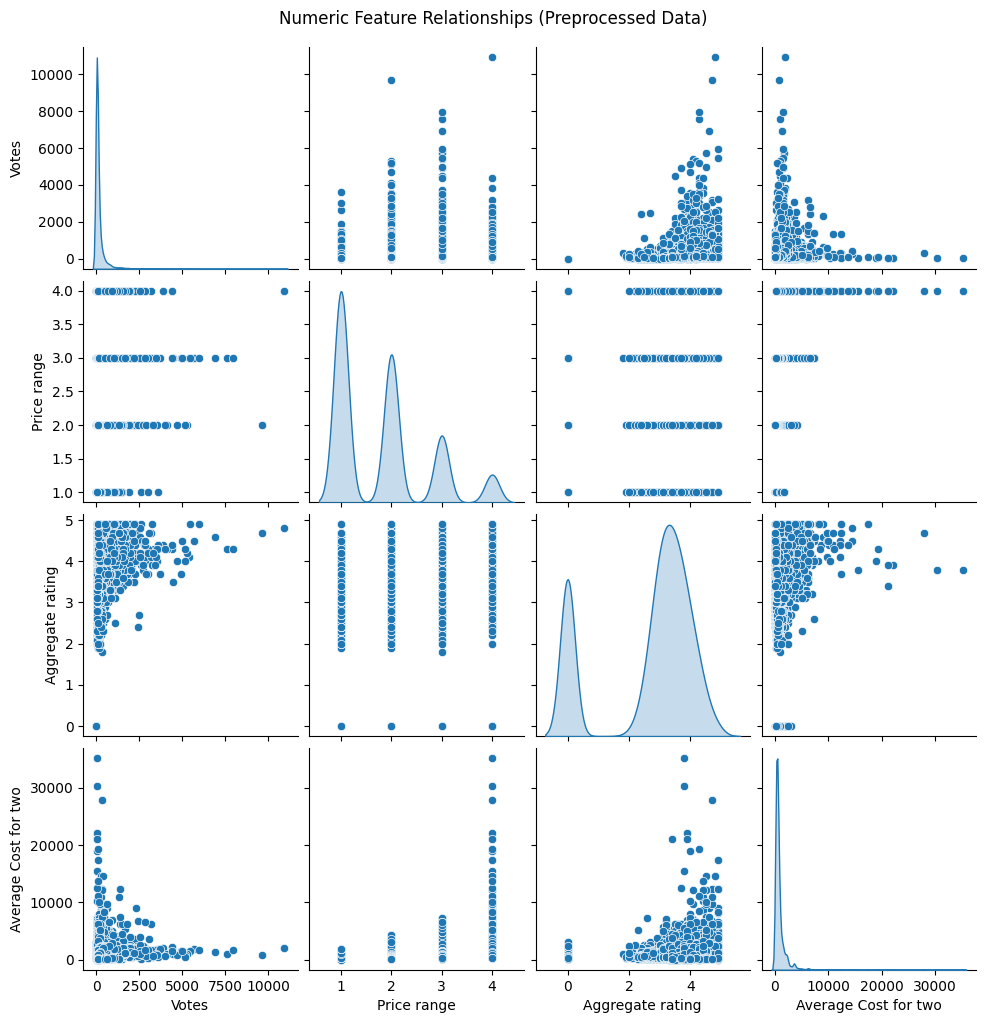

In [48]:
numeric_subset = df_updated_foodora[
    ['Votes', 'Price range', 'Aggregate rating', 'Average Cost for two']
]

sns.pairplot(numeric_subset, diag_kind='kde')
plt.suptitle("Numeric Feature Relationships (Preprocessed Data)", y=1.02)
plt.show()

### Export Cleaned Dataset

In [49]:
# Define export path
cleaned_file_path = os.path.join(processed_path, 'foodora_preprocessed.csv')

# Export cleaned dataset
df_updated_foodora.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset exported successfully to: {cleaned_file_path}")

Cleaned dataset exported successfully to: /content/drive/My Drive/Dataverse_Foodora_Project/03_Processed_Data/foodora_preprocessed.csv


## 9. Notebook 1: Data Preprocessing and Cleaning Summary

In this notebook, we focused on preparing a clean, consistent, and
analysis-ready dataset.

Key steps completed:

1. Loaded restaurant-level and country-level datasets.
2. Merged datasets using Country Code to obtain readable country names.
3. Dropped redundant and non-informative columns:
   - Country Code
   - Locality Verbose
   - Switch to order menu
4. Reordered columns to improve geographic and monetary readability.
5. Identified rating semantics and separated rated vs unrated restaurants.
6. Detected currency inconsistencies and corrected them using country-based logic.
7. Converted all restaurant costs into INR using static exchange rates.
8. Removed unreliable original cost and currency columns.
9. Finalized a single clean `Average Cost for two` column and `Currency` column.
10. Ensured the dataset is consistent, traceable, and suitable for EDA and modeling.

The resulting dataset is now standardized and ready for deeper analysis
and insight discovery.

In [51]:
# Create base map centered on India
density_map = folium.Map(location=[22.5, 78.9], zoom_start=5, tiles="CartoDB positron")

# Prepare heatmap data
heat_data = df_updated_foodora[['Latitude', 'Longitude']].dropna().values.tolist()

# Add heatmap
HeatMap(
    heat_data,
    radius=10,
    blur=15,
    gradient={
        0.2: 'blue',
        0.4: 'cyan',
        0.6: 'lime',
        0.8: 'orange',
        1.0: 'red'
    }
).add_to(density_map)

density_map